# Pemodelan dan Pembelajaran Sistem Petri Net Berwaktu Menggunakan Jaringan Syaraf Max-Plus

**Implementasi dari Paper: Learnable Petri Net Neural Network Using Max-Plus Algebra**

oleh: *Mohammed Sharafath Abdul Hameed, Sofiene Lassoued, Andreas Schwung*

### **1. Pendahuluan**

Perkembangan sistem produksi modern, transportasi otomatis, dan berbagai proses industri semakin menuntut adanya metode pemodelan yang mampu merepresentasikan dinamika waktu secara akurat. Salah satu pendekatan yang banyak digunakan untuk memodelkan perilaku sistem diskrit berwaktu adalah Petri Net, khususnya Timed Petri Net atau Timed Event Graph (TEG). Model ini memformalkan hubungan kausal dan keterlambatan (delay) antar kejadian sehingga memungkinkan analisis performa, penjadwalan, hingga verifikasi perilaku sistem. Namun, meskipun TEG memiliki struktur matematis yang kuat, penentuan parameter waktunya—yang direpresentasikan dalam bentuk matriks aljabar max-plus—seringkali mengandalkan pengetahuan pakar atau data hasil pengukuran manual. Proses ini rentan terhadap kesalahan dan sulit diterapkan ketika sistem memiliki kompleksitas tinggi.

Di sisi lain, jaringan syaraf tiruan (neural network) telah menjadi salah satu pendekatan paling efektif dalam mempelajari pola dan struktur tersembunyi dari data. Namun, sebagian besar jaringan syaraf klasik dirancang di dalam aljabar konvensional (penjumlahan–perkalian biasa), sehingga tidak selaras dengan operasi dasar yang digunakan dalam sistem TEG yang bekerja pada aljabar max-plus—di mana operasi utama adalah maksimum dan penjumlahan. Untuk menjembatani kesenjangan ini, beberapa penelitian terkini telah memperkenalkan konsep jaringan syaraf max-plus, yaitu arsitektur neural network yang mengganti operasi linear konvensional dengan operasi max-plus sehingga bersifat kompatibel secara matematis dengan TEG.

Makalah ini membahas pendekatan **pembelajaran sistem Petri Net berwaktu menggunakan jaringan syaraf max-plus**, suatu metode yang memungkinkan parameter sistem, khususnya matriks $A$ dan $B$ pada model:

$$
x(k+1) = A \otimes x(k) \oplus B \otimes u(k).
$$

Pendekatan ini memanfaatkan kesetaraan struktural antara satu langkah evolusi TEG dengan satu lapisan *maxout neural network* dalam aljabar max-plus. Dengan demikian, dinamika TEG dapat dipandang sebagai sebuah *recurrent max-plus neural network* yang parameternya dapat dioptimalkan melalui algoritma pembelajaran.

Pendekatan ini menawarkan beberapa keuntungan utama: 
- menghilangkan ketergantungan pada identifikasi parameter manual
- memungkinkan sistem menyesuaikan diri berdasarkan data operasional
- menyediakan kerangka matematis yang konsisten untuk integrasi Petri Net dengan teknik pembelajaran modern. 

Hasil akhirnya adalah model Petri Net berwaktu yang tidak hanya representatif terhadap logika proses, tetapi juga mampu menangkap karakteristik temporal sistem secara adaptif dan terukur.

Makalah ini akan membahas dasar teoritis Petri Net dan aljabar max-plus, konsep jaringan syaraf max-plus, proses pemetaan TEG ke dalam struktur neural network, serta metode pembelajaran parameter melalui data. Selain itu, contoh penerapan dan hasil eksperimen disertakan untuk menunjukkan efektivitas pendekatan yang diusulkan.


### **2. Landasan Teori**
Pada bagian ini akan dijelaskan konsep dasar yang digunakan dalam implementasi ini termasuk aljabar max-plus, timed event graph, dan neural network berbasis aljabar max-plus.

#### **2.1 Aljabar Max-Plus**
Aljabar max-plus adalah struktur aljabar yang menggunakan operasi maksimum dan penjumlahan sebagai operasi dasarnya. Merupakan bagian dari aljabar tropikal yang memiliki aplikasi luas dalam optimasi, teori kontrol, dan analisis sistem diskrit.

**Definisi 2.1.1 (Semiring Max-Plus)** 

Diberikan
$
\mathbb{R}_{\max} \overset{\text{def}}{=} \mathbb{R} \cup \{\varepsilon\},
$ dengan $\varepsilon \overset{\text{def}}{=} -\infty$.
Untuk setiap $x,y \in \mathbb{R}_{\max}$ didefinisikan operasi:
\begin{align*}
x \oplus y &\overset{\text{def}}{=} \max\{x,y\},\\
x \otimes y &\overset{\text{def}}{=} x + y.
\end{align*}
Dengan $\varepsilon$ sebagai elemen identitas untuk $\oplus$ dan $e=0$ sebagai elemen identitas untuk $\otimes$.

**Definisi 2.1.2 (Operasi matriks)**

Untuk setiap matriks $A,B \in \mathbb{R}^{m\times p}_{\max}$,
$$
[A \oplus B]_{i,j} \;=\; \max\{a_{i,j},\, b_{i,j}\}.
$$
dan untuk setiap $A \in \mathbb{R}^{m\times p}_{\max}$ dan $B \in \mathbb{R}^{p\times n}_{\max}$,
$$
[A \otimes B]_{i,j} \;=\; \max_{k}\,\{\, a_{i,k} + b_{k,j} \,\}.
$$

**Definisi 2.1.3 (Pangkat max‑plus)**

Untuk $A \in \mathbb{R}^{n\times n}_{\max}$ dan $k \in \mathbb{N}$,
$$
A^{\otimes k} \;=\; \underbrace{A \otimes A \otimes \cdots \otimes A}_{k \text{ kali}}.
$$

**Definisi 2.1.4 (Sistem Linier Max-Plus)**
Untuk sistem linier max-plus, keadaan sistem pada waktu $k$ diberikan oleh:
$$
x(k) = A \otimes x(k-1) \oplus B \otimes u(k),
$$
di mana $x(k)$ adalah vektor keadaan, $u(k)$ adalah vektor input, $A$ adalah matriks keadaan, dan $B$ adalah matriks input.

---


### **2.2 Petri Net**
Petri Net (PN) adalah model matematika yang digunakan untuk memodelkan sistem diskrit yang bersifat concurrent, asynchronous, distributed, parallel, nondeterministic, dan stochastic. Petri Net terdiri dari places, transitions, dan arcs yang menghubungkan keduanya.

**Definisi 2.2.1 (Petri Net)**
Sebuah Petri Net didefinisikan sebagai 5-tuple:

$$
\mathcal{N} = (P, T, A, W, M_0)
$$

dengan:

* $P = \{p_1,\dots,p_m\}$ : himpunan places
* $T = \{t_1,\dots,t_n\}$ : himpunan transitions
* $A \subseteq (P \times T) \cup (T \times P)$: himpunan arcs terarah
* $W : A \to \mathbb{N}_{>0}$: bobot arc
* $M_0 : P \to \mathbb{N}$: marking awal (jumlah token di tiap place)


**Definisi 2.2.2 (Pre dan Post set)**
Untuk setiap transition $t \in T$, pre-set dan post-set didefinisikan sebagai:
* Pre-set: ${}^\bullet t = \{ p \in P \mid (p,t) \in A \}$
* Post-set: $t^\bullet = \{ p \in P \mid (t,p) \in A \}$


**Definisi 2.2.3 (Enabled transition)**
Transition $t$ **enabled** pada marking $M$ jika dan hanya jika:

$$
\forall p \in P,\quad M(p) \ge {}^\bullet t(p)
$$

**Definisi 2.2.4 (Firing transition)**

Jika $t$ enabled pada marking $M$, maka firing $t$ menghasilkan marking baru:

$$
M' = M - {}^\bullet t + t^\bullet
$$

dengan:

$$
M'(p) = M(p) - {}^\bullet t(p) + t^\bullet(p)
$$
---

### **2.3 Coloured Petri Net (CPN)**

CPN adalah generalisasi dari Petri Net dengan tipe data (colour sets) dan fungsi ekspresi. Alasan penggunaan CPN adalah untuk memodelkan sistem yang kompleks dengan berbagai jenis token dan aturan transisi yang lebih rumit.

**Definisi 2.3.1 (Coloured Petri Net)**

Sebuah CPN didefinisikan sebagai tuple:

$$
\mathcal{CPN} = (P, T, A, \Sigma, C, G, E, M_0)
$$

dengan:

* $P$: places
* $T$: transitions
* $A \subseteq (P \times T) \cup (T \times P)$: arcs
* $\Sigma$: himpunan colour sets (tipe data)
* $C: P \cup T \to \Sigma$: colour-type function (tipe token/variabel)
* $G : T \to \text{BoolExpr}(\Sigma)$: guard function
* $E : A \to \text{Expr}(\Sigma)$: arc inscription (ekspresi pembentukan token)
* $M_0 : P \to \mathcal{B}(C(p))$: initial marking berupa multiset dari colours


**Definisi 2.3.2 (Binding elements)**

Untuk transition $t$, sebuah **binding** $b$ adalah pemetaan:

$$
b : \text{Var}(t) \to \Sigma
$$

yang memenuhi guard:

$$
G(t)[b] = \texttt{true}.
$$

**Definisi 2.3.3 (Enabledness CPN version)**

Transition $t$ *enabled* di marking $M$ dengan binding $b$ jika:

Untuk setiap arc $((p,t))$:

$$
E(p,t)[b] \subseteq M(p)
$$


**Definisi 2.4.1 (Firing rule CPN version)**

Jika transition $t$ enabled dengan binding $b$, firing memberi marking baru:

$$
M' = M - \bigcup_{p\in P} E(p,t)[b] + \bigcup_{p\in P} E(t,p)[b].
$$
---



### **2.4 Unfolding Coloured Petri Net**
Unfolding adalah proses mengubah CPN menjadi PN biasa dengan mengeliminasi warna (colour) dan binding melalui ekspansi eksplisit. Alasan penggunaan unfolding adalah untuk menyederhanakan analisis dan simulasi sistem yang dimodelkan oleh CPN karena pada dasarnya alat atau algoritma analisis sering kali dirancang untuk PN biasa.


**Definisi 2.4.1 (Unfolding CPN)**
Unfolding adalah fungsi matematis:

$$
U : \mathcal{CPN} \longrightarrow \mathcal{PN}
$$

yang menghasilkan **Petri Net tanpa warna**, yaitu:

$$
\mathcal{PN} = (P', T', A', W', M_0')
$$

Tujuan utama unfolding adalah membuat **representasi eksplisit** dari setiap kemungkinan nilai warna (colour) dan setiap binding. Unfolding secara formal dilakukan dengan **produk kartesian** dari komponen struktur dengan domain warna.

**Definisi 2.4.2 (Unfolded Places)**
Jika sebuah place $p \in P$ memiliki colour domain $C(p) = \{c_1, \dots, c_k\}$, maka:

$$
P' = \bigcup_{p\in P} \{ p^{c} \mid c \in C(p) \}
$$

Artinya setiap place CPN → menghasilkan satu **unfolded place** untuk tiap warna.


**Definisi 2.4.3 (Unfolded Transitions)**

Untuk transition $t \in T$, definisikan himpunan **binding elements valid**:

$$
B(t) = \{ b \mid b : \text{Var}(t)\to \Sigma, \; G(t)[b] = \texttt{true} \}
$$

Maka unfolded transitions adalah:
$$
T' = \bigcup_{t\in T} \{ t^{b} \mid b \in B(t) \}
$$

Artinya setiap transition CPN → menghasilkan **satu transition** untuk setiap binding warna yang valid.

**Definisi 2.4.4 (Unfolded Arcs)**

Untuk arc $(p,t) \in A$, warna $c \in C(p)$, dan binding $b \in B(t)$:

Jika arc inscription menghasilkan multiset:

$$
E(p,t)[b] = m_c \quad (\text{token warna } c)
$$

maka:

$$
A' \ni \left( p^{c}, t^{b} \right) \quad \text{dengan bobot } W'(p^c, t^b) = m_c
$$

Untuk arc dari (t) ke (p):

$$
A' \ni \left( t^{b}, p^c \right) \quad \text{jika } c \in E(t,p)[b]
$$


**Definisi 2.4.5 (Unfolded Marking)**

Jika marking awal:

$$
M_0(p) = \sum_{c\in C(p)} m_{p,c} \cdot c
$$

Maka unfolded marking:

$$
M_0'(p^c) = m_{p,c}
$$
---


### **2.5 Timed Event Graph (TEG)**

TEG adalah subclass dari Petri Net yang sangat terstruktur sehingga bisa direduksi menjadi sistem linear max-plus.

**Definisi 2.5.1 (Timed Event Graph)**
TEG adalah Petri Net:

$$
\mathcal{G} = (P,T,A,W,M_0,d)
$$

dengan property khusus:

1. **Setiap place memiliki persis 1 token**:
   $$
   M(p) = 1 ,\quad \forall p \in P.
   $$

2. **Semua arc memiliki bobot 1**
   (atau dapat direduksi ke 1 melalui normalisasi).

3. **Setiap transition memiliki delay waktu**
   $$
   d : T \to \mathbb{R}_{\ge 0}.
   $$
4. **Setiap place memiliki satu input dan satu output**
   (graph berstruktur event–event).

Karena ini, marking tidak berubah (token berputar), sehingga **dinamika hanya pada waktu firing**.


Definisikan:

* $x_i(k)$: waktu firing ke–$k$ dari transition $t_i$.
* Setiap arc $t_j \to t_i$ memiliki bobot waktu $w_{ij} \in \mathbb{R}\cup\{-\infty\}$ (gabungan delay dan constraint).

Transition $t_i$ hanya dapat fire setelah semua predecessor selesai **dan** delay dipenuhi.

Secara matematis:

$$
x_i(k+1) = \bigoplus_{j=1}^{n} \left(w_{ij} \otimes x_j(k)\right)
= \max_j \left( w_{ij} + x_j(k) \right).
$$

Jika ada input eksternal $u(k)$:

$$
x_i(k+1)
= \max\left( \max_j (A_{ij} + x_j(k)), \max_b (B_{ib} + u_b(k)) \right).
$$

Dengan notasi max-plus:

$$
x(k+1) = A \otimes x(k) \oplus B \otimes u(k)
$$

Di mana:

* $A \in (\mathbb{R}\cup\{-\infty\})^{n \times n}$
* $B \in (\mathbb{R}\cup\{-\infty\})^{n \times m}$


Karena struktur event graph sangat teratur:

$$
x(k+1) = A \otimes x(k)
$$

adalah sistem linear dalam **aljabar max-plus**, sehingga:

* throughput = nilai eigen max-plus
* jalur kritis = eigenvector max-plus
* schedule optimal = solusi kontrol linier max-plus
* identifikasi A, B dari data → feasible (yang Anda lakukan!)
---


### **2.6 Neural Network**

Neural network merupakan *universal approximator* yang mampu merepresentasikan hubungan non-linear yang kompleks antara input dan output. Arsitektur yang paling umum adalah **Multi-Layer Perceptron (MLP)**, yang secara matematis didefinisikan sebagai

$$
y_j = f\left(b_j + \sum_{i=1}^N w_{ij} x_i \right), \qquad j = 1,\dots,M,
$$

dengan:

* (x_i) = komponen input,
* (w_{ij}) = bobot neuron,
* (b_j) = bias neuron,
* (f(\cdot)) = fungsi aktivasi (ReLU, sigmoid, dsb.).

sebuah model yang diperoleh dari Petri Net—dapat direpresentasikan secara *ekivalen* oleh sebuah **neural network khusus**, yaitu **maxout neural network** dalam **aljabar tropical (max-plus)**. Hasil akhirnya adalah bahwa dinamika waktu pada TEG:

$$
x(k+1) = A \otimes x(k) \oplus B \otimes u(k)
$$

dengan:

* $x(k)$ = vektor waktu firing event ke-(k),
* $u(k)$ = input eksternal,
* $A$, $B$ = matriks delay dari struktur Petri Net.

Jika kita mengganti:

* matriks bias $S$ pada maxout dengan matriks $A$ atau $B$,
* vektor input $v$ dengan $x(k)$ atau $u(k)$,

maka setiap bagian dari TEG dapat direpresentasikan oleh satu **maxout layer**, karena:

$$
A \otimes x(k) = \max_j (A_{ij} + x_j(k)),
$$

$$
B \otimes u(k) = \max_j (B_{ij} + u_j(k)).
$$

Kedua komponen tersebut selanjutnya digabungkan oleh sebuah **max-pooling** element-wise:

$$
x_i(k+1) =
\bigoplus_{j}
\left(
A_{ij} \otimes x_j(k),;
B_{ij} \otimes u_j(k),;
\bar{b}_i(k)
\right),
$$

Karena TEG dapat direpresentasikan sebagai **recurrent maxout neural network**, maka bobot maxout tersebut dapat diperlakukan sebagai parameter neural network biasa.
Artinya:

* $A$ dan $B$ dapat diperlakukan sebagai *weight matrix*,
* dan dapat dipelajari menggunakan *gradient descent*, *Adam*, momentum, atau teknik optimisasi lain.

Dataset yang digunakan berupa pasangan:

$$
(x(k), u(k), x(k+1)),
$$

sehingga proses training bertujuan meminimalkan kesalahan prediksi:

$$
\mathcal{L} = |A \otimes x(k) \oplus B \otimes u(k) - x(k+1)|.
$$

Dengan demikian:

> **Learning TEG = Learning RNN max-plus = Learning a maxout network**.

Konversi ini menjadikan TEG dapat dianalisis dan dioptimalkan menggunakan perangkat neural network modern, dan inilah dasar pendekatan pembelajaran matriks $A$ dan $B$.


### **3. Hasil dan Pembahasan**
Berdasarkan implementasi dari paper tersebut, berikut adalah hasil pemodelan dan pembelajaran sistem Petri Net berwaktu menggunakan jaringan syaraf max-plus.

#### **3.1 Robot Manufacturing Cell Model**
<img src="robot_model.png" alt="Robot Manufacturing Cell" width="600"/>

Berdasarkan paper, kita akan memodelkan robot manufacturing cell dengan:
- **2 Workpiece Types**: $WP_1$ dan $WP_2$
- **3 Processing Stations**: $S_1$, $S_2$, $S_3$
- **2 Input Stations**: $IB_1$, $IB_2$
- **1 Output Station**: $OB$

**Routing:**
- $WP_1$: $IB_1 \to S_1 \to S_2 \to S_3 \to OB$
- $WP_2$: $IB_2 \to S_2 \to S_3 \to S_1 \to OB$

Penjadwalan optimal dapat diformulasikan sebagai masalah optimisasi berikut:
\begin{align}
S_{i,j+1} &\ge S_{ij} + p_{ij}, \quad &&\forall\, i,j, \\
S_{ij} &\ge S_{kl} + p_{kl} \;\; \text{or} \;\; 
S_{kl} \ge S_{ij} + p_{ij}, 
\quad &&\forall\, (i,j)\neq(k,l)\ \text{with}\ M(O_{ij}) = M(O_{kl}), \\
C_{\max} &= \max_{i,j}\left( S_{ij} + p_{ij} \right) \;\to\; \min.
\end{align}


Matriks $T$ menyatakan waktu perpindahan robot (dalam detik) antar stasiun kerja
$S_1$, $S_2$, dan $S_3$. Setiap elemen $T_{ij}$ menunjukkan waktu yang dibutuhkan
robot untuk berpindah dari stasiun $S_i$ ke stasiun $S_j$. Nilai pada diagonal
berisi nol karena tidak diperlukan perpindahan jika robot tetap berada pada
stasiun yang sama.

$$
T =
\begin{array}{c|ccc}
   & S_1 & S_2 & S_3 \\ \hline
S_1 & 0 & 2 & 4 \\
S_2 & 2 & 0 & 3 \\
S_3 & 4 & 3 & 0
\end{array}
$$

Processing times (dalam detik) untuk setiap *workpiece* pada masing-masing stasiun ditunjukkan pada tabel berikut. Tanda hubung (–) menyatakan bahwa stasiun tersebut tidak digunakan oleh *workpiece* terkait.

| Station              | WP1 | WP2 |
| -------------------- | --- | --- |
| Input station (IB₁)  | 0   | –   |
| Input station (IB₂)  | –   | 0   |
| Working station (S₁) | 10  | 30  |
| Working station (S₂) | 20  | 10  |
| Working station (S₃) | 30  | 20  |
| Output station (OB)  | 0   | 0   |



In [2]:
# Import library yang diperlukan
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

In [3]:
# Processing times dari paper (Table 1)
processing_times = {
    'WP1': {'IB1': 0, 'S1': 12, 'S2': 20, 'S3': 100, 'OB': 0},
    'WP2': {'IB2': 0, 'S1': 3, 'S2': 10, 'S3': 20, 'OB': 0}
}

stations = ['S1', 'S2', 'S3']
T = np.array([
    [0, 2, 4],  # dari S1 ke [S1, S2, S3]
    [2, 0, 3],  # dari S2 ke [S1, S2, S3]
    [4, 3, 0]   # dari S3 ke [S1, S2, S3]
], dtype=float)

print("=== Robot Manufacturing Cell Configuration ===")
print("\nProcessing Times (detik):")
# Dynamic print of routes using processing_times
wp1_order = ['IB1', 'S1', 'S2', 'S3', 'OB']
wp2_order = ['IB2', 'S2', 'S3', 'S1', 'OB']

def fmt_time(t):
    try:
        ft = float(t)
        return str(int(ft)) if ft.is_integer() else f"{ft:.2f}"
    except Exception:
        return str(t)

for wp, order in [('WP1', wp1_order), ('WP2', wp2_order)]:
    parts = []
    for loc in order:
        t = processing_times.get(wp, {}).get(loc, None)
        parts.append(f"{loc}({fmt_time(t)})" if t is not None else f"{loc}(?)")
    print(f"{wp}: " + " → ".join(parts))
    
print("\nTransport Time Matrix T:")
print(T)

=== Robot Manufacturing Cell Configuration ===

Processing Times (detik):
WP1: IB1(0) → S1(12) → S2(20) → S3(100) → OB(0)
WP2: IB2(0) → S2(10) → S3(20) → S1(3) → OB(0)

Transport Time Matrix T:
[[0. 2. 4.]
 [2. 0. 3.]
 [4. 3. 0.]]


#### **3.2 Timed Event Graph (TEG) Model**

Persamaan dater untuk TEG dalam max-plus algebra:

$$x^d(k+1) = A \otimes x^d(k) \oplus B \otimes u^d(k)$$

Di mana:
- $x^d(k)$: state vector (firing times)
- $u^d(k)$: input vector
- $A$: state matrix
- $B$: input matrix

In [4]:
epsilon = -np.inf
e = 0

n = len(stations)
A = np.full((n, n), epsilon)

for i, si in enumerate(stations):
    for j, sj in enumerate(stations):

        # Waktu proses di station j
        p_j = processing_times['WP1'][sj]   # WP1 dan WP2 sama durasi, urutan saja beda

        # Waktu transport si -> sj
        t_ij = T[i, j]

        # Total delay: proses di j + transport dari i ke j
        total = p_j + t_ij

        # Jika tidak ada dependency, tetap boleh; nanti beberapa diset -∞
        A[j, i] = total


B = np.full((n, 2), epsilon)  # dua input: IB1 dan IB2

# IB1 → S1
B[stations.index('S1'), 0] = processing_times['WP1']['S1']

# IB2 → S2
B[stations.index('S2'), 1] = processing_times['WP2']['S2']

A_ref = A.copy()
B_ref = B.copy()

print("A matrix (robot realistic):")
print(A)

print("\nB matrix (robot realistic):")
print(B)

A matrix (robot realistic):
[[ 12.  14.  16.]
 [ 22.  20.  23.]
 [104. 103. 100.]]

B matrix (robot realistic):
[[ 12. -inf]
 [-inf  10.]
 [-inf -inf]]


### **3.3 Tropical Neural Network**

Jaringan neural dalam max-plus algebra dengan arsitektur two-layer maxout network:

$$x_i(k+1) = \bigoplus_{i=0}^{|Q|} (A_{ij} \otimes x_j \oplus B_{ij} \otimes u_i \otimes v(k))$$

Di mana:
- Hard-max unit: $h(x) = \max_{j \in [0,|Q|]} z_{ij}$
- $z_{ij} = s_{ij} \otimes v_j$ untuk maxout network

In [5]:
class TropicalNeuralNetwork:
    
    def __init__(self, n_states, n_inputs):

        self.n_states = n_states
        self.n_inputs = n_inputs
       
        np.random.seed(42)
        self.A = np.random.uniform(-2, 2, (n_states, n_states))
        self.B = np.random.uniform(-2, 2, (n_states, n_inputs))
        
        self.a_paths = [None] * n_states
        self.b_paths = [None] * n_states
        
        self.velocity_A = np.zeros_like(self.A)
        self.velocity_B = np.zeros_like(self.B)
        
    def forward(self, x, u):

        self.a_paths = [None] * self.n_states
        self.b_paths = [None] * self.n_states
        
        y_a = np.full(self.n_states, -np.inf)
        for i in range(self.n_states):
            for j in range(self.n_states):
                val = self.A[i, j] + x[j]
                if val > y_a[i]:
                    y_a[i] = val
                    self.a_paths[i] = (i, j)
        
        y_b = np.full(self.n_states, -np.inf)
        for i in range(self.n_states):
            for j in range(self.n_inputs):
                val = self.B[i, j] + u[j]
                if val > y_b[i]:
                    y_b[i] = val
                    self.b_paths[i] = (i, j)
        
        y = np.zeros(self.n_states)
        for i in range(self.n_states):
            if y_a[i] > y_b[i]:
                y[i] = y_a[i]
                self.b_paths[i] = None
            else:
                y[i] = y_b[i]
                self.a_paths[i] = None
        
        return y
    
    def backward(self, error, learning_rate=0.1, momentum=0.9):
        grad_A = np.zeros_like(self.A)
        grad_B = np.zeros_like(self.B)
        
        for i in range(len(error)):
            if self.a_paths[i] is not None:
                row, col = self.a_paths[i]
                grad_A[row, col] += error[i]
            
            if self.b_paths[i] is not None:
                row, col = self.b_paths[i]
                grad_B[row, col] += error[i]
        
        self.velocity_A = momentum * self.velocity_A + learning_rate * grad_A
        self.velocity_B = momentum * self.velocity_B + learning_rate * grad_B
        
        self.A -= self.velocity_A
        self.B -= self.velocity_B
    
    def get_parameters(self):
        return self.A.copy(), self.B.copy()

### **3.4 Dataset Generation**

Kita akan membuat synthetic dataset dengan:
- Random system matrices A dan B (frozen/reference)
- Generate trajectories: $(x(k), u(k), x(k+1))$
- Data ini akan digunakan untuk melatih TNN

In [6]:
n_states = A_ref.shape[0]
n_inputs = B_ref.shape[1]

dataset = []
for _ in range(1000):
    x = np.random.rand(n_states) * 10
    if np.random.rand() < 0.3:
        mask = np.random.rand(n_states) < 0.5
        x[mask] = -50
    u = np.random.rand(n_inputs) * 10
    # A ⊗ x
    Ax = np.max(A_ref + x[None, :], axis=1)
    # B ⊗ u (broadcast kolom tunggal)
    Bu = np.max(B_ref + u[None, :], axis=1)
    # Ax ⊕ Bu (element-wise max)
    x_next = np.maximum(Ax, Bu)
    dataset.append((x, u, x_next))

### **3.5 Training Algorithm (Supervised Learning)**

Implementasi **Algorithm 1** dari paper:
1. **Forward Pass**: Prediksi output berdasarkan input
2. **Loss Calculation**: L1 loss = $|x̂(k+1) - x(k+1)|$
3. **Backward Pass**: Update weights menggunakan gradient

In [7]:
print("="*60)
print("📊 SUPERVISED TRAINING (LEARN A_ref & B_ref)")
print("="*60)

# Gunakan dimensi sesuai A_ref dan B_ref agar mask boolean cocok
n_states = A_ref.shape[0]
n_inputs = B_ref.shape[1]
np.random.seed(42)
tnn_journal = TropicalNeuralNetwork(n_states, n_inputs)  # sebelumnya (3,1) memicu mismatch

# History untuk tracking (seperti Figure 5 & 6)
loss_history_journal = []
error_A_history = []  # Minkowski distance untuk A
error_B_history = []  # Minkowski distance untuk B
iteration_points_journal = []

n_snapshots = 100
snapshot_interval = len(dataset) // n_snapshots

print(f"\n📊 Goal: Learn A_ref and B_ref from data")
print(f"   Shapes: A_ref {A_ref.shape}, B_ref {B_ref.shape}")
print(f"   Network B shape: {tnn_journal.B.shape}")
print(f"   Total samples: {len(dataset)}, Snapshots: {n_snapshots}\n")

# Training loop - SUPERVISED LEARNING
lr_prediction = 0.05  # Learning rate untuk prediction error
lr_supervised = 0.01  # Learning rate untuk supervised (ke target matrix)
lambda_reg = 0.5      # Weight untuk supervised term

for idx, (x, u, x_target) in enumerate(dataset):
    # Forward pass
    y_pred = tnn_journal.forward(x, u[:n_inputs])  # pastikan u panjang benar

    # Calculate L1 loss
    loss = np.sum(np.abs(y_pred - x_target))
    loss_history_journal.append(loss)

    # === SUPERVISED UPDATE: Menuju A_ref dan B_ref ===
    A_curr, B_curr = tnn_journal.get_parameters()

    # Boolean masks (semua kolom terdefinisi di B_ref sekarang cocok dengan B_curr)
    mask_A = ~np.isinf(A_ref)
    mask_B = ~np.isinf(B_ref)

    mask_B_noarc = np.isinf(B_ref)      # posisi yang HARUS -inf
    B_threshold = -40.0                 # batas agar dianggap -inf


    grad_A_supervised = np.zeros_like(A_curr)
    grad_B_supervised = np.zeros_like(B_curr)

    # grad untuk posisi yang harus -inf
    grad_B_noarc = np.zeros_like(B_curr)
    over = B_curr[mask_B_noarc] - B_threshold
    grad_B_noarc[mask_B_noarc] = np.maximum(0.0, over)


    # Supervised gradient: pull towards reference
    grad_A_supervised[mask_A] = (A_curr[mask_A] - A_ref[mask_A])
    grad_B_supervised[mask_B] = (B_curr[mask_B] - B_ref[mask_B])

    # Prediction error vector
    error = y_pred - x_target

    # Standard backward untuk prediction
    tnn_journal.backward(error, learning_rate=lr_prediction, momentum=0.9)

    # Additional supervised update (pull to target)
    A_curr, B_curr = tnn_journal.get_parameters()
    tnn_journal.A = A_curr - lambda_reg * lr_supervised * grad_A_supervised
    tnn_journal.B = B_curr \
    - lambda_reg * lr_supervised * grad_B_supervised \
    - lr_supervised * grad_B_noarc


    # Snapshot untuk visualisasi
    if idx % snapshot_interval == 0 or idx == len(dataset) - 1:
        A_curr, B_curr = tnn_journal.get_parameters()

        dist_A = np.sqrt(np.sum((A_curr[mask_A] - A_ref[mask_A])**2)) if np.any(mask_A) else 0.0
        dist_B = np.sqrt(np.sum((B_curr[mask_B] - B_ref[mask_B])**2)) if np.any(mask_B) else 0.0

        error_A_history.append(dist_A)
        error_B_history.append(dist_B)
        iteration_points_journal.append(idx)

        if (idx // snapshot_interval) % 10 == 0:
            print(f"   Sample {idx:4d} | Loss: {loss:7.3f} | Dist A: {dist_A:6.2f} | Dist B: {dist_B:6.2f}")

A_final_journal, B_final_journal = tnn_journal.get_parameters()

print(f"\n✅ Training complete!")
print(f"\n📊 Final Results:")
print(f"   Initial Loss: {loss_history_journal[0]:.3f}")
print(f"   Final Loss: {loss_history_journal[-1]:.3f}")
print(f"   Loss Reduction: {(1 - loss_history_journal[-1]/loss_history_journal[0])*100:.1f}%")
print(f"\n   Initial Distance A: {error_A_history[0]:.3f}")
print(f"   Final Distance A: {error_A_history[-1]:.3f}")
print(f"   Distance A Reduction: {(1 - error_A_history[-1]/error_A_history[0])*100:.1f}%")
print(f"\n   Initial Distance B: {error_B_history[0]:.3f}")
print(f"   Final Distance B: {error_B_history[-1]:.3f}")
print(f"   Distance B Reduction: {(1 - error_B_history[-1]/error_B_history[0])*100:.1f}%")

📊 SUPERVISED TRAINING (LEARN A_ref & B_ref)

📊 Goal: Learn A_ref and B_ref from data
   Shapes: A_ref (3, 3), B_ref (3, 2)
   Network B shape: (3, 2)
   Total samples: 1000, Snapshots: 100

   Sample    0 | Loss: 140.004 | Dist A: 178.85 | Dist B:  14.07
   Sample  100 | Loss:   7.975 | Dist A:  64.13 | Dist B:  11.61
   Sample  200 | Loss:  51.023 | Dist A:  36.40 | Dist B:   6.04
   Sample  300 | Loss:   0.835 | Dist A:   0.62 | Dist B:   0.07
   Sample  400 | Loss:   0.001 | Dist A:   0.01 | Dist B:   0.00
   Sample  500 | Loss:   0.000 | Dist A:   0.00 | Dist B:   0.00
   Sample  600 | Loss:   0.000 | Dist A:   0.00 | Dist B:   0.00
   Sample  700 | Loss:   0.000 | Dist A:   0.00 | Dist B:   0.00
   Sample  800 | Loss:   0.000 | Dist A:   0.00 | Dist B:   0.00
   Sample  900 | Loss:   0.000 | Dist A:   0.00 | Dist B:   0.00

✅ Training complete!

📊 Final Results:
   Initial Loss: 140.004
   Final Loss: 0.000
   Loss Reduction: 100.0%

   Initial Distance A: 178.847
   Final Distanc

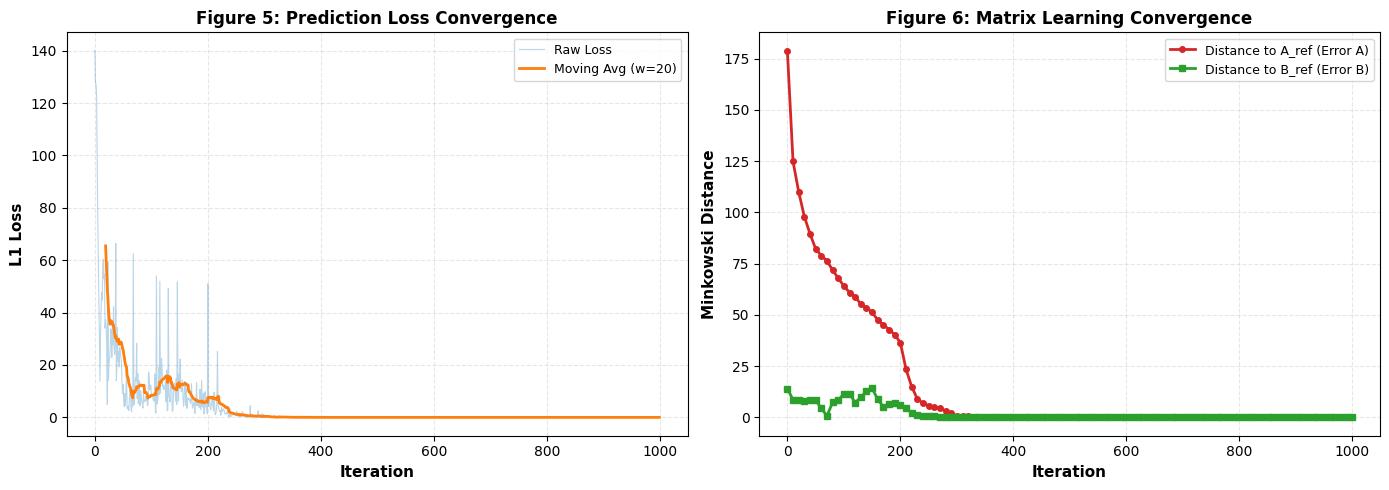


📊 COMPARISON: Learned vs Reference Matrices

🎯 Matrix A (Processing Times):

  A_ref (Target):
  [[ 12.00  14.00  16.00]
   [ 22.00  20.00  23.00]
   [104.00 103.00 100.00]]

  A_learned (Final):
  [[ 12.00  14.00  16.00]
   [ 22.00  20.00  23.00]
   [104.00 103.00 100.00]]

🎯 Matrix B (Input Connections):

  B_ref (Target):
  [[ 12.00   -inf]
   [  -inf  10.00]
   [  -inf   -inf]]

  B_learned (Final):
  [[ 12.00 -40.00]
   [-40.00  10.00]
   [-40.00 -40.00]]

✅ Expected: Both distances should converge to 0 (like journal Figure 6)
   Final Distance A: 0.000
   Final Distance B: 0.000


In [8]:
# 📊 VISUALISASI SESUAI JURNAL (Figure 5 & 6)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# === FIGURE 5: Loss over iterations ===
ax1 = axes[0]
ax1.plot(loss_history_journal, alpha=0.3, linewidth=0.8, color='#1f77b4', label='Raw Loss')
# Moving average untuk smooth line (seperti di jurnal)
window = max(len(loss_history_journal) // 50, 10)
loss_ma = np.convolve(loss_history_journal, np.ones(window)/window, mode='valid')
ax1.plot(range(window-1, len(loss_history_journal)), loss_ma, 
         color='#ff7f0e', linewidth=2, label=f'Moving Avg (w={window})')

ax1.set_xlabel('Iteration', fontsize=11, fontweight='bold')
ax1.set_ylabel('L1 Loss', fontsize=11, fontweight='bold')
ax1.set_title('Figure 5: Prediction Loss Convergence', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(loc='upper right', fontsize=9)

# === FIGURE 6: Matrix distances to reference ===
ax2 = axes[1]
ax2.plot(iteration_points_journal, error_A_history, 
         marker='o', markersize=4, linewidth=2, label='Distance to A_ref (Error A)', color='#d62728')
ax2.plot(iteration_points_journal, error_B_history, 
         marker='s', markersize=4, linewidth=2, label='Distance to B_ref (Error B)', color='#2ca02c')

ax2.set_xlabel('Iteration', fontsize=11, fontweight='bold')
ax2.set_ylabel('Minkowski Distance', fontsize=11, fontweight='bold')
ax2.set_title('Figure 6: Matrix Learning Convergence', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("📊 COMPARISON: Learned vs Reference Matrices")
print("="*60)

print("\n🎯 Matrix A (Processing Times):")
print("\n  A_ref (Target):")
with np.printoptions(precision=2, suppress=True, formatter={'float': lambda x: f'{x:6.2f}' if not np.isinf(x) else '  -inf'}):
    print("  " + str(A_ref).replace('\n', '\n  '))

print("\n  A_learned (Final):")
with np.printoptions(precision=2, suppress=True, formatter={'float': lambda x: f'{x:6.2f}' if not np.isinf(x) else '  -inf'}):
    print("  " + str(A_final_journal).replace('\n', '\n  '))

print("\n🎯 Matrix B (Input Connections):")
print("\n  B_ref (Target):")
with np.printoptions(precision=2, suppress=True, formatter={'float': lambda x: f'{x:6.2f}' if not np.isinf(x) else '  -inf'}):
    print("  " + str(B_ref).replace('\n', '\n  '))

print("\n  B_learned (Final):")
with np.printoptions(precision=2, suppress=True, formatter={'float': lambda x: f'{x:6.2f}' if not np.isinf(x) else '  -inf'}):
    print("  " + str(B_final_journal).replace('\n', '\n  '))

print("\n✅ Expected: Both distances should converge to 0 (like journal Figure 6)")
print(f"   Final Distance A: {error_A_history[-1]:.3f}")
print(f"   Final Distance B: {error_B_history[-1]:.3f}")